# Homework 1

Hi. Welcome to your first assignment.😁

As you learned, word embeddings have revolutionized the way we represent words in machines. They allow us to capture semantic meanings and relationships between words in a dense vector format. In this homework, you'll first try to construct your own word embeddings and identifying challenges in the process. Later, you'll compare these with pre-trained embeddings to realize their power and efficiency. We'll conclude with a dive into the advanced world of transformers, showcasing the pinnacle of NLP's capabilities.

You are free to discuss the problems and ways to approach them with your classmates, but be sure to not cheat. **Cheating will not be tolerated.**


## Import the Libraries you need

In [1]:
import nltk
import sklearn as sk
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

from IPython.display import clear_output

## Make the data ready

The dataset that we will use is Stanford Sentiment Treebank (SST).The SST is one of the most widely used datasets for sentiment analysis. It is unique because, in addition to providing labels for entire sentences, it also provides sentiment labels for individual phrases and subtrees within those sentences. The sentiment labels range from very negative to very positive, which contains 11,855 sentences and 215,154 unique phrases.

you can download the dataset with runing the cell below:

In [2]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanfordSentimentTreebank.zip
clear_output()

Now let us label the data and transform it into a dataframe so we can use it in next parts.

In [11]:
sentences = pd.read_csv('stanfordSentimentTreebank/datasetSentences.txt', sep='\t')

# label the data
sent_labels = pd.read_csv('stanfordSentimentTreebank/sentiment_labels.txt', sep='|')
sent_labels['label'] = sent_labels['sentiment values'].apply(lambda x: 1 if x >= 0.5 else 0)

# Merge dataframes
final_data = pd.merge(sentences, sent_labels, left_on='sentence_index', right_on='phrase ids')

final_data = final_data[['sentence', 'label']]

final_data.head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,0
2,Effective but too-tepid biopic,1
3,If you sometimes like to go to the movies to h...,0
4,"Emerges as something rare , an issue movie tha...",0


Run the cell below to


1.   Convert the text and the labels to numpy arrays
2.   Convert the labels to numeral integers



In [23]:
text_data = list(final_data['sentence'])
label_list = list(final_data['label'])
text_data = np.array(text_data)
label_list = np.array(label_list)

## Exercise 1: Statistical Word Embeddings

Word embeddings are numerical vector representations of words that capture their meanings based on context. They are crucial because they allow machines to understand and process human language more efficiently, facilitating tasks like text analysis, machine translation, and sentiment analysis.

In this exercise, we are going to attempt to make our very own word-embedding. Specifically, we will construct a co-occurrence word embedding. A co-occurrence word embedding is a type of word embedding in which for $N$ words, an $N \times N$ matrix is created with $n_{i,j}$ determining the number of times the word in position $i$ appears adjacent to the word in position $j$.

### 1.1 Data cleaning
First, in order to have a better performing model, we should clean our sentences as much as we can. This usually boils down to removing the punctuations, and uppercase words.

Complete the function below such that given a numpy array (or list) of sentences, it returns another list of sentences such that the returned list has its punctuations removed, HTML tags removed, links removed, and upper case words converted to lower case.

In [12]:
import re
def clean_sentences(list_of_sentences) :
  cleaned_sentences = []
  for sentence in list_of_sentences:
    # Remove HTML tags
    sentence = re.sub(r'<.*?>', '', sentence)

    # Remove links
    sentence = re.sub(r'http\S+', '', sentence)

    # Remove punctuations and convert to lowercase
    sentence = re.sub(r'[^\w\s]', '', sentence).lower()

    cleaned_sentences.append(sentence)
  return cleaned_sentences


#Give an example here that showcases the result of your code


# Example usage
sentences = ["<p>This is an <a href='http://example.com'>example</a> sentence!</p>",
             "Please remove punctuation.",
             "Convert UPPERCASE words to lowercase.",
             "https://www.example.com is a link."]
cleaned = clean_sentences(sentences)
print(cleaned)

['this is an example sentence', 'please remove punctuation', 'convert uppercase words to lowercase', ' is a link']


### 1.2 Word Tokenization

in order to construct our word embedding, we need to tokenize the sentences. You will later use this function to tokenize the sentences of the dataset.

Complete the below function such that given a numpy array (or list) of sentences, it returns a list of lists where each list corresponds with a sentence and each element of it is a tokenized word.

Example: Suppose that you you have the list ["i love natural language processing", "i love cats"]. Given this list, your function should return [["i","love","natural","language","processing"]["i","love","cats"]].

In [13]:
def tokenizer(list_of_sentences) :
  tokenized_sentences = [sentence.split() for sentence in list_of_sentences]
  return tokenized_sentences

#Give an example here that showcases the result of your code

# Example usage
sentences = ["i love natural language processing", "i love cats"]
tokenized = tokenizer(sentences)
print(tokenized)

[['i', 'love', 'natural', 'language', 'processing'], ['i', 'love', 'cats']]


### 1.3. Word  Vectorization
Machine learning algorithms usually don't understand words in the string format. So it is better to convert the strings into a numeral format. While it is possible to construct a co-occurrence based  word embedding wihtout this step, it is far easier to just vectorize our words now rather than later as it is far easier to manipulate integers.

Complete the function below such that given a numpy array (or a list) of tokenized sentences (list of lists), a mapping is created between the words and a numeric value.

Example: Suppose that your sentences contain the words "i", "love", and "cats", what you want to do is to create a dictionary such that {"i" : 0, "love" : 1, "cats" : 2}. Having this knowledge, apply this to the entire dataset.

In [14]:
def sentences_to_mapping(tokenized_sentences):
    mapping = {}
    word_index = 0  # Start with index 0 for the first word

    for sentence in tokenized_sentences:
        for word in sentence:
            if word not in mapping:
                mapping[word] = word_index
                word_index += 1

    return mapping

# Example usage
tokenized_sentences = [["i", "love", "natural", "language", "processing"], ["i", "love", "cats"]]
word_mapping = sentences_to_mapping(tokenized_sentences)
print(word_mapping)


{'i': 0, 'love': 1, 'natural': 2, 'language': 3, 'processing': 4, 'cats': 5}


Good job :). now that we have managed to create a mapping between each word and a numeric value, we should be able to vectorize our sentences, that is, replace the words in the tokenized sentences with their numeric value.

Complete the function below such that given a list of tokenized sentences and a mapping that maps each word to a numeric value, another list of tokenized sentences is returned such that each word is replaced with their numeric  value.

Example: Suppose that we have [["i", "love", "Cats"]], and {"i" : 0, "love" : 1, "cats" : 2}, your function should return [[0,1,2]].

In [17]:
def transform_vectorize(tokenized_sentences, mapping):
    vectorized_sentences = []

    for sentence in tokenized_sentences:
        vectorized_sentence = [mapping[word] for word in sentence if word in mapping]
        vectorized_sentences.append(vectorized_sentence)

    return vectorized_sentences

# Example usage
tokenized_sentences = [["i", "love", "cats"]]
word_mapping = {"i": 0, "love": 1, "cats": 2}
vectorized = transform_vectorize(tokenized_sentences, word_mapping)
print(vectorized)


[[0, 1, 2]]


### 1.4. Constructing the Word Embeddings

Now that we have all the tools we need for cleaning, tokenizing, and vectorizing our data, we can actually create the word embedding that we want.

Complete the function below such that given a vectorized list of sentences, and a window that determines the number of words to look at in each direction, returns an $N \times N$ matrix such that $N$ is the number of words in our vocabulary and $n_{i,j}$ is the number of times the word in poistion $i$, appears adjacent to the word in position $j$.

Example: Suppose that we have the vectorized sentences [[0,1,2]], and window of 2. Our function should create the following $3 \times   3$ matrix.

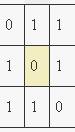

In [21]:
def cons_word_embedding(vectorized_sentences, window=2):
    # Determine the size of the vocabulary
    vocab_size = max(max(sentence) for sentence in vectorized_sentences) + 1

    # Initialize the co-occurrence matrix with zeros
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size))

    for sentence in vectorized_sentences:
      sentence_length = len(sentence)
      for i, target_word in enumerate(sentence):
        # Define the context window boundaries
        start = max(0, i - window)
        end = min(sentence_length, i + window + 1)

        # Update the co-occurrence matrix within the context window
        for j in range(start, end):
          if j != i:
            co_occurrence_matrix[target_word][sentence[j]] += 1

    return co_occurrence_matrix

# Example usage
vectorized_sentences = [[0, 1, 2]]
window_size = 2
co_occurrence = cons_word_embedding(vectorized_sentences, window_size)
print(co_occurrence)


[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


Now that we have written the function, lets run our data through your pipeline and create the word embedding, you are free to make very small detail modifications to the code below, but **don't** change the overall structure.

In [25]:
cleaned_text_data = clean_sentences(text_data)
tokenized_sentences = tokenizer(cleaned_text_data)
mapping = sentences_to_mapping(tokenized_sentences)
vectorized_sentences = transform_vectorize(tokenized_sentences, mapping)
co_occurrence_word_embedding = cons_word_embedding(vectorized_sentences, window = 2)
print(co_occurrence_word_embedding)

[[164.  11. 820. ...   0.   1.   0.]
 [ 11.   0.   3. ...   0.   0.   0.]
 [820.   3.   8. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


### 1.5. Analyzing the Word Embeddings
Now that we have constructed our word embedding, it is time to analyze our construct. Answer the questions below


---
1.   Compare this approach to other methods such as TF-IDF and Deep Learning based Word Embeddings, how are they different? what are the advantages and the disadvantages of each approach?



**⏩ANSWER:**


#### Co-Occurrence-Based Word Embeddings
1. Methodology:

  These embeddings are generated by counting the frequency of word co-occurrences within a specified window in a large corpus. The resulting matrix encodes how words are likely to appear together.

2. Advantages:

  - **Interpretability**: Co-occurrence matrices are relatively easy to interpret. The values in the matrix represent word relationships.
  - **Simple to compute**: They are computationally less intensive compared to deep learning-based embeddings.

3. Disadvantages:

  - **Limited context**: Co-occurrence embeddings often work within a fixed context window, which might not capture long-range word associations.
  - **High dimensionality**: The co-occurrence matrix can be large, especially with a large vocabulary.


#### Deep Learning-Based Word Embeddings (Word2Vec, GloVe, etc.)

1. Methodology:

  These methods use neural networks to learn distributed representations of words based on the contexts in which they appear. Word2Vec, for example, creates word vectors that encode semantic similarity and relationships between words.

2. Advantages:

  - Captures rich semantic information and word relationships.
  - Effective in various NLP tasks, including sentiment analysis, machine translation, and text classification.
  - Can capture long-range dependencies between words.

3. Disadvantages
  - **Computationally expensive**: Training deep learning-based embeddings can be computationally intensive.
  - **Lack of interpretability**: These embeddings are challenging to interpret compared to simpler methods like co-occurrence matrices.
  - Requires large datasets: Deep learning-based embeddings benefit from large corpora.

In summary, Co-occurrence-based embeddings are simple and interpretable but have limitations in capturing long-range relationships. TF-IDF is effective for document-level tasks but does not provide rich word semantics. Deep learning-based embeddings excel in capturing word semantics and relationships but require large datasets and significant computational resources.

---



2.   How would you handle Out-of-Vocabulary words in this approach? Give 2 solutions and discuss their feasibility as well as their advantages and disadvantages.

**⏩ANSWER:**


#### 1. Subword Representations (e.g., FastText)

1. **Feasibility:**

  Highly feasible and widely used, with readily available tools like FastText.

2. **Advantages:**

  - **Coverage:** Effective for handling OOV words by breaking words into subword units (n-grams or character-level embeddings).
  - **Flexibility:** Can capture the morphological structure of words and handle unseen variations.
  - **Easy to implement:** Pre-trained models and libraries like FastText are available.

3. **Disadvantages:**

  - **Increased dimensionality:** Higher dimensionality compared to traditional word embeddings, leading to increased memory and computation requirements.
  - **Loss of word-specific meaning:** While effective at handling OOV words, subword embeddings might not fully capture the exact meaning of entire words.

#### 2. Special Tokens

1. **Feasibility:**

  Highly feasible and straightforward to implement by adding special tokens to the vocabulary.

2. **Advantages:**
  - **Explicit handling:** Provides an explicit and transparent way to deal with OOV words, allowing customization for different NLP tasks.
  - **Compatibility:** Can be used with any word embedding method, both traditional and deep learning-based embeddings.

3. **Disadvantages:**

  - **Limited semantic representation:** OOV words are represented by a special token, which may not capture their semantic meaning.
  - **Loss of information:** May not fully leverage the context of OOV words in the text, potentially leading to a loss of information.
  - **Contextual challenges:** Substituting OOV words with a special token may not be suitable for all NLP tasks, especially those where precise word meaning is crucial.

---

## Exercise 2: Correcting the Statistical Word Embedding
So far, we have managed to create our own word embedding, good job😁. In this part, we are going to discuss the shortcomings of our current approach and try to ameliorate it with some simple soltsions.

### 2.1. Problems with the Current Word Embedding

Answer the questions below

1 - Note that right now, each embedding of an arbitrary word is $N$ dimensional. Discuss why this can be a problem? Does an arbitrarily large word embedding result in better model performance? Discuss your answer and mention why you think your answer is the case.


---



**⏩ANSWER:**


2 - Suppose that you have created a word embedding $W$ matrix from an arbitrary dataset. You now wish to use your dataset in a real Deep Learning model. Is it a good idea to further train your statistical word embedding in a downstream Deep Learning task? Why?



---



**⏩ANSWER:**

### 2.2. Dimension Reduction

In this question, we wish to reduce the dimensionality of our word embeddings such that they are more in line with modern word embeddings.

Complete the function below such that given a word embedding of size $N \times N$, a word embedding of size $N \times X$ is returned with $X < N$.

Hint: For this purpose, explore  PCA and TruncatedSVD

In [ ]:
def reduce_dimension(embeddings, x = 64) :
  #reduced_embeddings = ? Write your code here
  return reduced_embeddings
#Give an example here that showcases the result of your code

### 2.3. Visualizing the word embeddings  

Remember that a good word embedding is a one that carries the meanings of the words in itself. Here, we want to visualize the word embedding that have created and analyze the spatial positions of each word.

Complete the function below such that given a word embedding matrix, the data points are plotted in a 2D space.

Hint: You have to use the "reduce_dimension" function to draw and the mapping that we created in the previous question to understand the mapping between data points and words.

Your final plot should be similar to this plot.

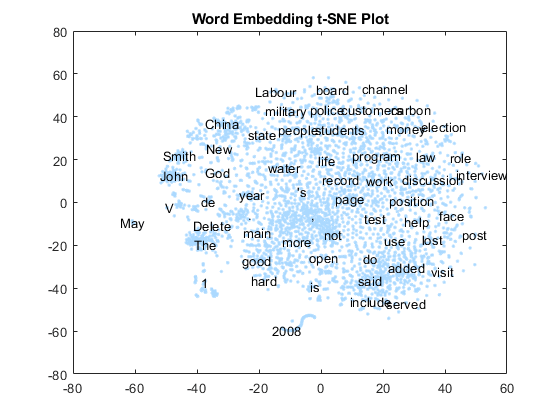

In [ ]:
from matplotlib import pyplot as plt
def plot_embeddings(word_embeddings) :
  #plot your embeddings here

plot_embeddings(co_occurrence_word_embedding)

Having visualized our word embedding, it is easier to analyze its properties and talk about its qualities.

Answer the questions below based on your plot.



1.   What words are clustered together? What words are not? give 3 pairs of words that you think are correctly clustered together and 3 pairs of words that you think should be clustered together but are not.



---



**⏩ANSWER:**


2.   Why do you think some related words are not clustered together? How do you think we can solve this problem?



---



**⏩ANSWER:**



## Exercise 3: Explore Pre-trained Word Embeddings


### 3.1 Loading & Exploration:

As you know Word embeddings are dense vector representations of words in a continuous vector space. Instead of building these embeddings from scratch, which can be computationally intensive and require a significant amount of data, pretrained word embeddings offer an efficient alternative. They are generated using vast amounts of text data and then made available for public use.

Load the GloVe embeddings using the gensim library.
Choose three words of your preference. For each of these words, retrieve and display the top 5 words that are most similar based on the embeddings. Use cosine similarity as your metric.


In [ ]:
#To_Do



### 3.2 Visualization:

We have a set of 8 selected words which should include a mix of:
Words with clear gender associations (e.g., 'king', 'queen').
Words related to technology (e.g., 'computer', 'keyboard').
Words representing geographical entities (e.g., 'city', 'town').

You can select your own words based on the explanation above.

In [ ]:
words = ['king', 'queen', 'man', 'woman', 'computer', 'keyboard', 'city', 'town']

Use Principal Component Analysis (PCA) to reduce the dimensionality of these word embeddings to 2D.
Visualize these 2D embeddings on a scatter plot, ensuring each word is labeled on the graph.

In [ ]:
#To_Do



Do the same visualization with same words using the word embedding that you created in exercise 1.

In [ ]:
#To_Do


### 3.3 Interpretation :

Based on the visualization, describe any observed clusters or relationships among the words. What might be the reason for such relationships or patterns?


---



**⏩ANSWER:**

Explain the difference between these two scatter plot in section 3.2.



---



**⏩ANSWER:**





## Exercise 4: Dive into Hugging Face and Transformers

In this exercise, we'll explore the world of Hugging Face, a leading platform in natural language processing, and its Transformers library. Transformers have revolutionized the way we handle text data in machine learning. We'll specifically focus on fine-tuning a transformer model for a sentiment analysis task. Dive in to grasp the intricacies of these powerful models and their applications!

### 4.1 Getting Started with Transformers:

Install the transformers library and import the necessary modules.


In [ ]:
#install transformer library
!pip install transformers


Choose a pretrained model (like BERT) from Hugging Face's model hub. Load the model and its corresponding tokenizer. What architecture does the chosen model belong to? Provide a brief overview of its main features.


---



**⏩ANSWER:**

In [ ]:
#TO_DO

model_name =
tokenizer =
model =


### 4.2 Tokenization:

Use the tokenizer you've loaded to tokenize the sentences that are in the sentences list and print the tokens.

In [ ]:
sentences = ["Transformers have revolutionized NLP.",
             "Hugging Face provides an amazing platform for pretrained models."]

#TO_DO


Explain the significance of the following components in the tokenized output: input_ids, attention_mask, and token_type_ids.


---



**⏩ANSWER:**

### 4.3 Fine-tuning and Classification:

Using Hugging Face's datasets library, load a sentiment classification dataset of your choice.

In [ ]:
!pip install datasets

In [ ]:
#To_Do
# Load IMDb dataset
dataset =

Tokenize the dataset and prepare it for training.

In [ ]:
#To_Do

# Tokenize the dataset
def tokenize_function(examples):
  tokenized =
  return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Fine-tune the pretrained model you've chosen on this dataset for sentiment classification.

Report the evaluation metrics(accuracy, precision and recall) on a held-out test set.

you can set the hyperparameters on your choice.

In [ ]:
# Load model


# Train the model


# Evaluate the model


### 4.4 Exploration:

Choose a task other than sentiment classification (e.g., named entity recognition, question answering). Load a pretrained model suitable for this task from Hugging Face's model hub.

Provide a brief overview of how the model is structured to handle this specific task and give an example of its usage.


---



**⏩ANSWER:**






In [ ]:
#TO_DO
